# Ce projet fonctionne avec les versions des package suivants:

- matplotlib==3.9.0
- pandas==2.2.2
- seaborn==0.13.2
- missingno==0.5.2
- scikit-learn==1.5.1

## The Data
This is a dataset of food products listing the ingredients and nutritional facts of more than 300,000 foods from over 150 countries in the world. The data is meant to be free to the public to help users decode food labels, and make better food choices in general. The dataset contains more than 300,000 rows over 163 columns. However, as we will see there are a lot of missing or obviously incorrect values.<br/>
Generalities:

- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
- fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product


# Importation des packages

In [4]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.api as sm
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import tkinter as tk
from tkinter import filedialog

import missingno as msno
import ipywidgets as widgets
from wordcloud import WordCloud
from IPython.display import display, HTML,clear_output

# Nettoyer et Filtrer les Features et Produits

## 1.1. Collecter et Préparer les Données Brutes
### 1. Charger les données dans un DataFrame Pandas

In [114]:
def project_init():
    global data 
    display(HTML("<h1 style='color: navy'>Open Food Facts</h1>"))
    print('Initialisation du projet...', end='\r')
    filepath ='datas/openfoodfacts.csv'
    target ='additives_fr'
    selected = ['energy_100g','salt_100g','alcohol_100g','cocoa_100g','potassium_100g','nutrition_grade_fr']
    data = pd.read_csv(f"{filepath}", sep="\t", encoding="utf-8", on_bad_lines="skip", low_memory=False)
    print(' '*len('Initialisation du projet...'), end='\r')
    print('Projet chargé')
    return filepath, target, selected, data

In [8]:
def select_file():
    print("charger le nouveau fichier")
    root =tk.Tk()
    root.withdraw()

    filepath = filedialog.askopenfilename(
        title="Choisissez votre fichier csv",
        filetypes=(("Fichiers CSV","*.csv"), ("Tous les fichiers","*.*"))
    )
    print(' '*len("charger le nouveau fichier"),end='\r')
    print("chargement en cours...")
    root.destroy()

    if filepath:
        try:
            data = pd.read_csv(f"{filepath}", sep="\t", encoding="utf-8", on_bad_lines="skip", low_memory=False)
            print(' '*len("chargement en cours..."),end='\r')
            print(f"Fichier chargé avec succès depuis le chemin: {filepath}")
            return data
        except Exeption as e:
            print("Erreur lors du chargement du fichier:",e)
    else:
        print("Aucun fichier sélectionné.")

In [9]:
# changement d'index
# data = data.set_index('code')

In [99]:
# Analyse de la dimension de la base de données
data.shape

(320772, 162)

In [101]:
data.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,248939.000000,248939.000000,0.0,248939.000000,0.0,0.0,2.611130e+05,857.000000,243891.000000,...,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1.141915e+03,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6.447154e+03,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,3.770000e+02,49.400000,0.000000,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN,1.100000e+03,300.000000,5.000000,...,7.200000,23.000000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,NaN,3.000000,0.000000,NaN,0.000000,NaN,NaN,1.674000e+03,898.000000,20.000000,...,7.400000,51.000000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN
max,NaN,31.000000,2.000000,NaN,6.000000,NaN,NaN,3.251373e+06,3830.000000,714.290000,...,8.400000,100.000000,25.000000,100.000000,NaN,2842.000000,40.000000,40.000000,NaN,NaN


In [11]:
#Analyse de l'ensemble des variables de la base de données
# data.info(verbose=True, show_counts=True)

In [12]:
# data.isna().sum()

In [13]:
url='https://world.openfoodfacts.org/data/data-fields.txt'
df_description = pd.read_csv(url, sep="\t", encoding="utf-8", comment='#', header=None)
fields={}
current_category=None
for index, row in df_description.iterrows():
    line =row[0]
    if line.startswith ('#'):
        continue
    if ':' in line:
        key, description=line.split(':',1)
        fields[key.strip()]=description.strip()
    elif len(line.strip()) == 0:
        continue
    else:
        current_category=line.strip()

for key in list(fields.keys()):
    print(f"{key}: {fields[key]}")

See https: //world.openfoodfacts.org/data for more information.
Generalities: 
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
List of fields: 
code: barcode of the product (can be EAN-13 or internal codes for some food stores), for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix
url: url of the product page on Open Food Facts
creator: contributor who first added the product
created_t: date that the product was added (UNIX timestamp format)
created_datetime: date that the product was added (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
last_modified_t: date that the product page was last modified
product_name: name of the product
quantity: quantity and unit
packaging: shape, material
origins: origins of ingredients
manufacturing_places: places where manufactured or transformed
first_packaging_code_geo: coordinates corresponding to the first packaging code indicated
countries: list of countries where the p

In [14]:
# Analyse du type de variables dans la base de données
pd.set_option('display.max_rows',None)
# print(data.dtypes)

## 1.2. Identifier et Sélectionner les Features Pertinentes
### 1.Lister les Features (Colonnes) :

In [16]:
def feature_list(data):
    features = data.columns
    return features

### 2.Séparer les Features Quantitatives et Qualitatives :

In [18]:
def split_features(data):
    quantitative_features = data.select_dtypes(include=['float64','int64'])
    qualitative_features = data.select_dtypes(include=['object'])
    return quantitative_features,qualitative_features

## 1.3. Choisir une Cible

### 1.Choisir une Feature Cible avec Moins de 50% de Valeurs Présentes :

In [21]:
def target_choice(qualitative_features, data, target):
    display(HTML("<h3>Choisir une Feature Cible avec Moins de 50% de Valeurs Présentes</h3>"))
    # Calcule le pourcentage de valeurs manquantes pour chaque colonne
    missing_percentages = data.isnull().mean() *100
    
    #Filtrer les features ayant moins de 50% de valeurs manquantes.
    features_with_less_than_50_missing = missing_percentages[missing_percentages > 50]
    
    # Trier par ordre décroissant de pourcentage de valeurs manquantes
    sorted_features = features_with_less_than_50_missing.sort_values(ascending=False)
    
    potential_targets = [feature for feature in sorted_features.index if feature in qualitative_features]

    print(f'{len(potential_targets)} cibles potentiels avec moins de 50% des valeurs / {len(qualitative_features.columns)} features dans l\'ordre. \nSelectionner votre cible dans la liste suivantes :')
    for index, feature in enumerate(potential_targets):
        nb_fill_each_value= data[feature].count()
        val_null= data[feature].isna().sum()
        percentage_fill_each_value = (nb_fill_each_value / len(qualitative_features) * 100).round(2)
        print(f"{index+1}: {feature}: {percentage_fill_each_value}% des valeurs présentes soit {nb_fill_each_value} valeurs")
    try:
        selected_index = int(input('Entrer l\'index de votre cible:'))
        target = potential_targets[selected_index-1]
        print("Feature cible selectionnée:", target)
    except IndexError:
        print("Invalid index. Please restart the selection process.")
    except ValueError:
        print("Invalid input. Please enter a numeric index.")
    return target

### Supprimer les Lignes (Produits) Sans Valeur Cible :


In [23]:
def clean_row_without_target(data,target):
    display(HTML("<h4>suppression des lignes sans cible...</h4>"))
    # print('suppression des lignes sans cible...',end='\r')
    data_nan = data[data[target].isna()]
    data_cleaned = data.dropna(subset=[target])
    result = data_cleaned.shape
    # print(' '*len('suppression des lignes sans cible...'), end='\r')
    print('✅ Lignes sans cible supprimées')
    return data_cleaned
#data_nan.shape

### 3.Séparer la Cible du Reste du Dataset :


In [25]:
def split_dataset_from_target(data_cleaned,target):
    display(HTML("<h4>Séparation de la cible du reste du jeu de données</h4>"))
    print('Séparation de la cible du reste du dataset...',end='\r')
    df_without_target = data_cleaned.drop(columns=[target])
    df_with_target=data_cleaned[target]
    print(' '*len('Séparation de la cible du reste du dataset...'),end='\r')
    print('✅ Cible séparée du reste du jeu de données')
    return df_without_target

## 1.4. Afficher les Taux de Remplissage des Features

In [27]:
def filling_rate_display(data_cleaned,df_without_target):
    display(HTML("<h3 style='color: navy'>Taux de remplissage</h3>"))
    print('Affichage en cours...',end='\r')
    filling_rates = data_cleaned.notnull().mean()*100
    sorted_value=df_without_target.count().sort_values(ascending=True)
    sorted_df =df_without_target[sorted_value.index]
    msno.bar(sorted_df)
    # msno.matrix(sorted_df)
    # msno.heatmap(sorted_df)
    print(' '*len('Affichage en cours...'),end='\r')

## 1.5. Sélectionner des Features Intéressantes

### Sélectionner les Features avec Plus de 50% de Valeurs Présentes :

In [30]:
def select_features_with_more_than_50(df_without_target):
    display(HTML("<h3>Sélectionner les Features avec Plus de 50% de Valeurs Présentes</h3>"))
    # Calcul le pourcentage de valeurs non nulles pour les colonnes quantitatives
    df_without_target=df_without_target.notnull().mean()*100

    # Sélectionne les features avec plus de 50% de valeurs non nulles
    selected_features = df_without_target[df_without_target>50].sort_values(ascending=True)

    # Créer un DataFrame pour afficher les résultats
    # selected_features = pd.DataFrame(selected_features,columns=['Features'])
    print('Features ayant plus de 50% de valeurs que vous pouvez sélectionner (triées par ordre croissant) :\n')
    for index, (feature, percentage) in enumerate(selected_features.items(), start=1):
        print(f'{index} : {feature} - {percentage:.2f}% de valeurs présentes')
    return selected_features.index

In [31]:
def features_selection(selected,selected_features):
    nb_element = int(input('Combien de feature voulez-vous utiliser (recommandé 3)'))
    print(f'Selectionnez 1 à {nb_element} éléments:\n')
    old_selected = selected
    selected = [] # Pour stocker les features choisis
    while len(selected) < nb_element:
        if len(selected)<nb_element:
            choice_index= input(f"Entrez le numéro de votre choix numéro {len(selected)+1} ou tapez fin pour garder le choix initial")
            if choice_index.lower()=='fin':
                if len(selected)==0:
                    selected = old_selected
                else:
                    return selected
            else:
                try:
                    choice_index= int(choice_index)-1
                    if 0<= choice_index <len(selected_features):
                        feature = selected_features[choice_index]
                        if feature not in selected:
                            selected.append(feature)
                            display(HTML(f'<p><b>Vous avez selectionné</b> {feature}</p>'))
                            display(HTML(f'<p>Features selectionnées: <b>{selected}</b></p>'))
                            # print(f'Vous avez selectionné {feature}')
                            # print(f'Features selectionnées:{selected}')
                        else:
                            print("Vous avez déjà sélectionné cette feature. Veuillez choisir une autre.")
                    else:
                        print('Numéro de choix invalide, veuillez entrer un numéro valide.')
                except ValueError:
                    print("Entrée invalide, veuillez entrer un numéro entier.")
    return selected

In [32]:
def clean_duplicate(data_cleaned, target, selected):
    num_rows, num_cols = data_cleaned.shape

    display(HTML("<h3 style='color: navy'>Nettoyage des doublons</h3>"))

    print(f'Nombre de lignes avant nettoyage : {num_rows}')

    columns_to_check = [target] + selected  # Ajoute 'target' à la liste 'selected'
    print(f'Est considéré comme doublons toutes les lignes ayant des valeurs identique sur l\'ensembles des colonnes {columns_to_check}')
    
    data_after_cleaned = data_cleaned.drop_duplicates(subset =columns_to_check)
    data_after_cleaned = data_after_cleaned.reset_index(drop=True)
    num_rows_after, num_cols_after = data_after_cleaned.shape

    print(f'Nombre de lignes après nettoyage : {num_rows_after}')
    return data_after_cleaned

# Automatisation Partie 1: Nettoyer et filtrer les features et produits

In [34]:
def clean_and_filter_features_and_products(filepath, target, selected, data):
    print('Paramètre par défaut:\n')
    print(f'chemin du fichier:\n --> {filepath}\n')
    print(f'Cible de l\'analyse:\n --> {target}\n')
    print(f'Features de l\'analyse:\n --> {selected}\n')
    
    
    default_params=input('Souhaitez-vous changer les paramètres par défault?\n O (Oui) / N (Non)')
    
    if default_params.lower() == "o":
        
        filepath_params=input('Souhaitez-vous changer de fichier?\n O (Oui) / N (Non)')
        
        if filepath_params.lower()=='o': # Change le fichier de jeu de données
            data = select_file()  #Fonction de selection du nouveau fichier
            feature_list(data) # Liste des colonnes avec le nouveau ficher
        
        quantitative_features, qualitative_features = split_features(data) #Features avec le nouveau ficher
        
        target_params=input(f'Souhaitez-vous changer la cible d\'analye? {target}\n O (Oui) / N (Non)')
        if target_params.lower()=='o':
            target = target_choice(qualitative_features, data, target) # Change la cible d'analyse
            data_cleaned = clean_row_without_target(data,target) # Supprime les ligne n'ayant pas de cible
            df_without_target = split_dataset_from_target(data_cleaned,target) #sépare et recupère un dataframe sans la colonne cible    
        print(f" Nouvelle cible d'analyse: {target}")
    
        selected_params=input(f'Souhaitez-vous changer de Features? actuellement {selected}\n O (Oui) / N (Non)')
        if selected_params.lower()=='o':
            if filepath_params.lower()!='o':
                data_cleaned = clean_row_without_target(data,target) # Supprime les ligne n'ayant pas de cible
                df_without_target = split_dataset_from_target(data_cleaned,target) #sépare et recupère un dataframe sans la colonne cible
            selected_features=select_features_with_more_than_50(df_without_target)      
            selected =features_selection(selected,selected_features)
        print(f'Nouvelles Features selectionnées:{selected}')    
    else:
        quantitative_features, qualitative_features = split_features(data)
        data_cleaned = clean_row_without_target(data,target)
        df_without_target = split_dataset_from_target(data_cleaned,target)
    
    data_clean_duplicate=clean_duplicate(data_cleaned,target, selected)
    filling_rate_display(data_cleaned,data_clean_duplicate)
    
    columns_to_keep = ['product_name','url'] + [target] + selected
    
    data_filtered = data_clean_duplicate[columns_to_keep]
    return data_filtered, quantitative_features, qualitative_features, target, selected

# Identifier et traitez les valeurs aberrantes

In [36]:
def missing_value_prop(data_filtered):
    display(HTML("<h3 style='color: navy;'>Proportion des valeurs manquantes de la cible et des features selectionnées</h3>"))
    data_filtered_copy=data_filtered.isnull().mean()
    
    data_filtered_copy=data_filtered_copy.sort_values(ascending=False)
    
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(12,8))
    
    sns.barplot(x=data_filtered_copy.index, y=data_filtered_copy.values, ax=ax,color='blue')
    
    ax.set_xlabel('Features')
    ax.set_ylabel('Proportion des valeurs manquantes')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Proportion des valeurs manquantes par features')
    plt.show()

In [37]:
font_paths = [
    '/Users/yann/FromNas/Training/IA Engineer/P3_santePublique/dejavu-fonts-ttf-2.37/ttf/DejaVuSans.ttf',  # DejaVu Sans
    '/Users/yann/Library/Fonts/NotoSansCJK.ttc',  # Noto Sans CJK pour les caractères chinois, japonais et coréens
    '/Users/yann/Library/Fonts/NotoSansThai-VariableFont_wdth,wght.ttf'
]
font_props = [fm.FontProperties(fname=font_path) for font_path in font_paths]
plt.rcParams['font.family'] = [fp.get_name() for fp in font_props]
def clean_text(text):
    return ''.join([char if ord(char)>=32 else '' for char in text])

In [38]:
def graph_analysis(data_filtered,target,selected):

    html_content = """
    <h3 style='color: navy;'>Graphe de distribution de la cible et des features selectionnées</h3>
    """
    display(HTML(html_content))
    quantitative_features, qualitative_features = split_features(data_filtered)
    threshold = 10
    threshold_target = 20
    
    value_counts_target = data_filtered[target].value_counts()
    to_keep_target = value_counts_target[value_counts_target>threshold_target].index
    data_filtered_backup = data_filtered.copy()
    data_filtered.loc[:,f'{target}_simplified'] = data_filtered[target].apply(lambda x: x if x in to_keep_target else 'Autres')
    
    plt.figure(figsize=(20, 6))
    
    if data_filtered[target].nunique()<20:
        display(HTML(f'<p> Moins de 20 valeur pour la cible: <b>{target} --> Affichage sous forme de pie chart</b></p>'))
        fig, ax =plt.subplots(figsize=(16,14))
        counts = data_filtered[target].value_counts()  # Comptez les occurrences de chaque catégorie
        ax.pie(counts, labels=None, autopct='%1.1f%%',  textprops={'size': 'smaller'},pctdistance=1.1)
        ax.legend(wedges, counts.index, title=target, loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))
        ax.axis('equal')
        plt.title(f'Distribution of {target}')
        plt.show()
        
    else:
        display(HTML(f'<p> Plus de 20 valeurs pour la cible: <b>{target} --> Affichage sous forme de diagramme en barres</b></p>'))
        sns.countplot(x=f'{target}_simplified', data=data_filtered)
        plt.title(f'Distribution of {target}')
        plt.xticks(rotation=90, fontsize=6)
        plt.show()
        
    check_feat_nbr = 0
    for feat in selected:
        check_feat_nbr +=1 
        if feat in qualitative_features.columns:
            display(HTML(f'<p> Feature <b>{feat}</b> est une variable qualitative --> Affichage sous forme de diagramme en barres</b></p>'))
            value_counts = data_filtered[feat].value_counts()
            to_keep = value_counts[value_counts>threshold].index
            data_filtered.loc[:,f'{feat}_simplified']=data_filtered[feat].apply(lambda x:x if x in to_keep else 'Autres')
            # print(f'{feat} is in')
            plt.figure(figsize=(20, 6))
            sns.countplot(x=f'{feat}_simplified', data=data_filtered)
            plt.title(f'Distribution of {feat}')
            plt.xticks(rotation=90, fontsize=8)
            plt.show()
            # plt.tight_layout()
        else:

            # Calculer quelques statistiques de base
            min_value = data_filtered[feat].min()
            max_value = data_filtered[feat].max()
            std_dev = data_filtered[feat].std()
            mean_value = data_filtered[feat].mean()
            range_value = max_value - min_value

            if min_value > 0:
                ratio = max_value / min_value
            else:
                ratio = float('inf')  # Si min_value est 0, le ratio est considéré comme infini
            
            # Critères pour décider d'utiliser une échelle logarithmique
            use_log_scale = (ratio > 1000) or (std_dev > mean_value)
     
            
            plt.figure(figsize=(20, 6))
            
            if use_log_scale:
                display(HTML(f'<p> Feature <b>{feat}</b> est une variable quantitative --> Affichage sous forme d\'histogramme</b></p>'))
                display(HTML(f'<p> Utilisation d\'une echelle logarithmique car trop de valeur pour un affichage noraml = <b>{data_filtered[feat].count()}</b></p>'))
                log_feat = np.log1p(data_filtered[feat])
                sns.histplot( x=log_feat, kde=True, bins='auto')
                plt.title(f'Distribution of {feat} en échelle logarithmique')
            else:
                display(HTML(f'<p> Feature <b>{feat}</b> est une variable quantitative --> Affichage sous forme d\'histogramme</b></p>'))
                display(HTML(f'<p> Utilisation d\'une echelle NON logarithmique car nombre de valeur = <b>{data_filtered[feat].count()}</b></p>'))
                sns.histplot( x=feat, kde=True, bins='auto',data=data_filtered)
                plt.title(f'Distribution of {feat}')               
            plt.xticks(rotation=90, fontsize=6)
            plt.show()
            
            
        if check_feat_nbr == len(selected):
            data_filtered=data_filtered_backup
            return data_filtered
    return data_filtered

In [39]:
def boxplot_before_IQR(quantitative_features,data_filtered):
    display(HTML("<h3 style='color: navy;'>Boxplot AVANT traitement des valeurs abérrantes</h3>"))
    for feature in data_filtered:
        if feature in quantitative_features.columns:
            sns.boxplot(x=feature, data=data_filtered)
            plt.title(f'Boxplot of {feature} with outliers')
            plt.show()

In [40]:
def box_outliers(quantitative_features,feature):
    Q1 = quantitative_features[feature].quantile(0.25)
    Q3 = quantitative_features[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = max(0,Q1 - 1.5 * IQR)
    upper_limit = Q3 + 1.5 * IQR
    outliers = (quantitative_features[feature]<lower_limit) | (quantitative_features[feature]>upper_limit)
    print(f'Outliers de {feature}')
    print(f'lower_limit de {feature}: {lower_limit}')
    print(f'upper_limit de {feature}: {upper_limit}')
    return outliers, lower_limit, upper_limit

In [41]:
def normal_indicator(feature,data_filtered):
    feature_data = data_filtered[feature].dropna()  # Supprimer les NaN pour éviter les erreurs

    # Calcul du skewness et du kurtosis
    skewness = stats.skew(feature_data)
    kurtosis = stats.kurtosis(feature_data,fisher=False)#Vrai kurtosis
    # excess_kurtosis = stats.kurtosis(feature_data)#Vrai kurtosis
    # print(f"Skewness: {skewness}")
    # print(f"Kurtosis réel: {kurtosis}")
    # print(f"Excès de kurtosis: {excess_kurtosis}")
    return skewness,kurtosis

In [42]:
def isolation_forest_calc(data_filtered, feature):
    # Récupération des données réelles de la feature sous forme de tableau 2D
    feature_data = data_filtered[[feature]].dropna()
    
    # Initialisation du modèle Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)

    # Ajustement du modèle et prédiction des outliers
    outliers_labels = iso_forest.fit_predict(feature_data.values.reshape(-1, 1))
    
    # Reindexer les labels pour correspondre à l'index de feature_data
    outliers_labels = pd.Series(outliers_labels, index=feature_data.index)
    
    return outliers_labels

In [43]:
def outliers_calc(quantitative_features,data_filtered):
    html_content=f"""
    <h3 style='color: navy;'>Boxplot APRÈS traitement des valeurs abérrantes</h3>
    Pour chacune de nos features, on calcul:</br>
    - Le Skewness et,</br>
    - le kurtosis.</br>
    Ces coefficients nous permettent de définir si nos distributions suivent une loi normal (Skweness = 0 et Kurtosis = 3 pour valider la loi normal)</br>
    Si la validation est confirmée, on utilise 'IQR' pour les valeurs abérrantes,</br>
    sinon on utilisera 'Isolation forest'
    """
    display(HTML(html_content))
    data_filtered_without_outliers = data_filtered.copy()
    for feature in data_filtered:
        if feature in quantitative_features.columns:
            skewness,kurtosis = normal_indicator(feature,data_filtered)
            if skewness != 0 and kurtosis!=3:
                display(HTML(f"<h4 style='color: navy;'>Feature {feature}</h4>"))
                print(f'Skewness différents de 0, ici: {skewness.round(2)} et kurtosis différents de 3, ici: {kurtosis.round(2)}')
                display(HTML("<p style='color: navy;'><b>Utilisation de la méthode Isolation forest</b></p>"))
                # print(f'Utilisation de la méthode Isolation forest')

                feature_data = data_filtered[feature].dropna()
                if feature_data.shape[0] == 0:
                    display(HTML(f"<p style='color: red;'>Pas de données valides pour {feature}. Skipping.</p>"))
                    continue
                    
                outliers_labels=isolation_forest_calc(data_filtered,feature)   
                
                # Filtrer data_filtered_without_outliers pour ne garder que les inliers
                inliers = outliers_labels[outliers_labels == 1].index
                data_filtered_without_outliers = data_filtered_without_outliers.loc[inliers]

                # Filtrer data_filtered pour ne garder que les inliers
                data_filtered = data_filtered.loc[outliers_labels[outliers_labels == 1].index]

                # Affichage des résultats
                # print(f"Outliers détectés dans {feature}: {sum(outliers_labels == -1)}")
         
                quant_data_df_outliers = data_filtered[[feature]]
            else:
                display(HTML(f"<h4 style='color: navy;'>Feature {feature}</h4>"))
                print(f'Skewness égale à 0, ici: {skewness.round(2)} et kurtosis égale à 3, ici: {kurtosis.round(2)}')
                display(HTML("<p style='color: navy;'>Utilisation de la méthode IQR</p>"))
                # print(f'Utilisation de la méthode IQR')
                outliers, lower_limit, upper_limit = box_outliers(quantitative_features,feature)
                
                # Filtrer les outliers selon la méthode IQR
                inliers = data_filtered_without_outliers[(data_filtered_without_outliers[feature] >= lower_limit) & 
                                                         (data_filtered_without_outliers[feature] <= upper_limit)].index
                
                
                quant_data_df_outliers = quantitative_features[(quantitative_features[feature]>=lower_limit) & 
                                                                (quantitative_features[feature]<=upper_limit)]
            sns.boxplot(x=feature, data=quant_data_df_outliers)
            plt.title(f'Boxplot of {feature} without outliers')
            plt.show()
    return data_filtered_without_outliers

In [44]:
def worcloud_graph(data_filtered,qualitative_features):
    columns_to_exclude = ['code','nutrition_grade_fr', 'url']  # Ajoutez d'autres colonnes ici si nécessaire
    display(HTML("<h3 style='color: navy;'>Nuage des mots les plus représentés pour les features qualitative</h3>"))

    for feature in data_filtered:
        if feature not in columns_to_exclude and feature in qualitative_features:
            text = ' '.join(str(x) for x in data_filtered[feature] if x is not None and not pd.isna(x))
            if text.strip() and any(c.isalpha() for c in text):
                wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
                plt.figure(figsize=(14, 8))
                plt.title(f'WordCloud for the feature: {feature}')
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.show()
            else:
                print(f"No valid data to generate wordcloud for the feature: {feature}. Possible only numeric or empty strings.")

In [45]:
def find_and_handles_outliers(data_filtered,target,selected,quantitative_features):
    missing_value_prop(data_filtered)
    data_filtered=graph_analysis(data_filtered, target,selected)
    # missing_prop(data_filtered)
    boxplot_before_IQR(quantitative_features,data_filtered)
    data_filtered=outliers_calc(quantitative_features,data_filtered)
    return data_filtered
    # worcloud_graph(data_filtered,qualitative_features)

# Étape 3 : Identifiez et traitez les valeurs manquantes

In [47]:
def title(title, title_size='h2'):
    if title_size == 'h2':
        display(HTML(f"<h2 style='color: navy;'>{title}</h2>"))
    elif title_size == 'h3':
        display(HTML(f"<h3 style='color: navy;'>{title}</h3>"))
    else:
        display(HTML(f"<h4 style='color: navy;'>{title}</h4>"))

In [48]:
def find_missing_value(data_filtered):
    plt.figure(figsize=(10, 6))
    msno.matrix(data_filtered)
    plt.show()

In [49]:
def simple_imputer(data_filtered):
    try:
        for feature in data_filtered.columns:
            if feature in qualitative_features.columns:
                display(HTML(f"<p>Utilisation de simple Imputer pour la feature {feature}</p>"))
                imputer = SimpleImputer(strategy='constant', fill_value='missing')
                data_filtered[feature]=imputer.fit_transform(data_filtered[[feature]]).ravel()
                display(HTML("<p>Simple Imputer a réussi à imputer les valeurs manquantes des variables qualitatives.</p>"))
                return data_filtered
    except Exception as e:
        display(HTML(f"<p>Erreur lors de l'imputation avec SimpleImputer: {str(e)}</p>"))
        return data_filtered

In [50]:
def KNN_imputer(data_filtered):
    try:
        
        numeric_data = data_filtered.select_dtypes(include=[np.number])
        
        impute_knn = KNNImputer(n_neighbors=2)
        numeric_data_imputed=impute_knn.fit_transform(numeric_data)
    
        # Convertir le résultat en DataFrame et réassigner les noms de colonnes
        numeric_data_imputed = pd.DataFrame(numeric_data_imputed, columns=numeric_data.columns)
    
        
        # Réassembler les données numériques et non numériques
        non_numeric_data=data_filtered.select_dtypes(exclude=[np.number])
        data_filtered_imputed=pd.concat([numeric_data_imputed,non_numeric_data], axis=1)
        display(HTML("<p>KNN Imputer a réussi à imputer les valeurs manquantes des variables quantitatives.</p>"))

        return data_filtered_imputed
        
    except Exception as e:
        display(HTML(f"<p>Erreur lors de l'imputation avec KNNImputer: {str(e)}</p>"))
        return data_filtered

In [51]:
def impute_zero(data_filtered):
    try:
        # Remplacer les valeurs manquantes par 0 dans toutes les colonnes numériques
        numeric_columns = data_filtered.select_dtypes(include=[np.number]).columns
        data_filtered[numeric_columns] = data_filtered[numeric_columns].fillna(0)
        return data_filtered
    except Exception as e:
        display(HTML("<p>Affectation de la valeur 0 a réussi pour les variables quantitatives.</p>"))
        return data_filtered

In [52]:
def select_imputation_type(options,description,tooltips):
    # Créer un groupe de boutons à bascule
    toggle_buttons = widgets.ToggleButtons(
        options=options,
        description=description,
        disabled=False,
        button_style='', 
        tooltips=tooltips,
    )
    
    # Afficher les boutons à bascule groupés
    display(toggle_buttons)
    
    # Retourner le widget pour que l'utilisateur puisse interagir avec
    return toggle_buttons

In [53]:
def imputation_value(data_filtered):
    quant_var_nbr=data_filtered.select_dtypes(include=['float64','int64']).shape[1]
    qual_var_nbr=data_filtered.select_dtypes(include=['object']).shape[1]

    html_content= f"""
    <p>il y a {quant_var_nbr} variable quantitatives et {qual_var_nbr} variable qualitatives.</p>
    <p>Nous allons définir la méthode de traitement des valeurs manquantes de ces 2 types de variables</p>
    <p>Vous pouvez laisser les paramètres par défaut. Dans ce cas les imputations des valeur manquantes seront:</p>
    <ul>
    <li>Variable qualitative: 'missing' pour toutes les valeurs manquantes.</li>
    <li>Variable quantitative: '0' à toutes les valeurs manquantes.</li>
    </ul>
    """
    display(HTML(html_content))
    
    default_choice = widgets.RadioButtons(
        options=['Garder les paramètres par défaut', 'Personnaliser les options'],
        description='Choix :',
        disabled=False
    )
    display(default_choice)
    
    output = widgets.Output()
    def on_radio_confirm_click(change):
            with output:
                clear_output(wait=True)
                if default_choice.value == 'Garder les paramètres par défaut':
                    display(HTML("<p>Vous avez choisi de garder les paramètres par défaut : 'missing' pour les qualitatives et '0' pour les quantitatives.</p>"))
                    simple_imputer(data_filtered)
                    find_missing_value(data_filtered)
                elif default_choice.value == 'Personnaliser les options':
                    display(HTML("<p>Personnalisez les options d'imputation :</p>"))
            
            
                    qual_imputation_choice = select_imputation_type(
                        options=['missing', 'KNN'],
                        description='Variables qualitative (texte): Affectation de la valeur missing ou utilisation de KNN',
                        tooltips=['Affectation de la valeur "missing"', 'Utilisation de la méthod KNN'])
                
                    # Choix pour les variables quantitatives
                    quant_imputation_choice = select_imputation_type(
                        description='Variables quantitative (nombre):',
                        options=['0', 'KNN'],
                        tooltips=['Affecter "0" aux valeurs manquantes', 'Utiliser la moyenne pour imputer les valeurs manquantes']
                    )
                    
                    def on_button_click(b):
                        qual_selected_choice = qual_imputation_choice.value
                        quant_selected_choice = quant_imputation_choice.value
                        with output:
                            clear_output(wait=True)
                            display(HTML(f"<p>Choix pour les variables qualitatives : <b>{qual_selected_choice}</b></p>"))
                            display(HTML(f"<p>Choix pour les variables quantitatives : <b>{quant_selected_choice}</b></p>"))
                
                            if qual_selected_choice =='missing':
                                simple_imputer(data_filtered)
                            elif qual_selected_choice =='KNN':
                                display(HTML("<p>La méthode KNN sera utilisée pour les variables qualitatives (implémentez cette partie si nécessaire).</p>"))
                
                            if quant_selected_choice =='0':
                                display(HTML("<p>Affectation de la valeur 0 pour les variables quantitatives.</p>"))
                                impute_zero(data_filtered)
                            elif quant_selected_choice =='KNN':
                                display(HTML("<p>Utilisation de la éthode KNN pour imputer les valeurs manquantes des variables quantitatives.</p>"))
                                KNN_imputer(data_filtered)
                
                            find_missing_value(data_filtered)
                            
                    # Créer un bouton pour valider la sélection
                    button = widgets.Button(description="Confirmer la sélection")
                    button.on_click(on_button_click)
                    # Afficher le bouton et la sortie
                    display(button)

    # Créer un bouton pour valider la sélection du bouton radio
    radio_confirm_button = widgets.Button(description="Confirmer le choix")
    radio_confirm_button.on_click(on_radio_confirm_click)
    display(radio_confirm_button)
    # default_choice.observe(on_default_choice_change, names='value')
    display(output)
            
        # def continue_with_selection(selected_choice):
        #     # Cette fonction peut contenir la suite de ton script en fonction de `selected_choice`
        #     print(f"Continuer avec la sélection : {selected_choice}")

In [54]:
def find_and_handles_missing_values(data_filtered):
    title(title="Identifiez et traitez les valeurs manquantes", title_size='h2')
    title(title ="Affichage des données manquantes Avant traitement des valeurs abérrantes", title_size='h3')
    # display(HTML("<h2>Identifiez et traitez les valeurs manquantes</h2>"))
    find_missing_value(data_filtered)
    title(title ="Affichage des données manquantes Après traitement des valeurs abérrantes", title_size='h3')
    # data_filtered= simple_imputer(data_filtered)
    imputation_value(data_filtered)

In [55]:
# find_and_handles_missing_values(data_filtered)

Projet chargé              


Paramètre par défaut:

chemin du fichier:
 --> datas/openfoodfacts.csv

Cible de l'analyse:
 --> additives_fr

Features de l'analyse:
 --> ['energy_100g', 'salt_100g', 'alcohol_100g', 'cocoa_100g', 'potassium_100g', 'nutrition_grade_fr']



Souhaitez-vous changer les paramètres par défault?
 O (Oui) / N (Non) o
Souhaitez-vous changer de fichier?
 O (Oui) / N (Non) n
Souhaitez-vous changer la cible d'analye? additives_fr
 O (Oui) / N (Non) o


36 cibles potentiels avec moins de 50% des valeurs / 56 features dans l'ordre. 
Selectionner votre cible dans la liste suivantes :
1: allergens_fr: 0.01% des valeurs présentes soit 19 valeurs
2: cities: 0.01% des valeurs présentes soit 23 valeurs
3: ingredients_from_palm_oil_tags: 1.51% des valeurs présentes soit 4835 valeurs
4: ingredients_that_may_be_from_palm_oil_tags: 3.65% des valeurs présentes soit 11696 valeurs
5: first_packaging_code_geo: 5.86% des valeurs présentes soit 18803 valeurs
6: cities_tags: 6.33% des valeurs présentes soit 20320 valeurs
7: origins_tags: 6.91% des valeurs présentes soit 22153 valeurs
8: origins: 6.92% des valeurs présentes soit 22190 valeurs
9: traces_tags: 7.58% des valeurs présentes soit 24329 valeurs
10: traces_fr: 7.59% des valeurs présentes soit 24352 valeurs
11: traces: 7.59% des valeurs présentes soit 24353 valeurs
12: allergens: 8.84% des valeurs présentes soit 28344 valeurs
13: emb_codes_tags: 9.14% des valeurs présentes soit 29303 valeurs
14:

Entrer l'index de votre cible: 8


Feature cible selectionnée: origins


✅ Lignes sans cible supprimées


✅ Cible séparée du reste du jeu de données   
 Nouvelle cible d'analyse: origins


Souhaitez-vous changer de Features? actuellement ['energy_100g', 'salt_100g', 'alcohol_100g', 'cocoa_100g', 'potassium_100g', 'nutrition_grade_fr']
 O (Oui) / N (Non) o


✅ Lignes sans cible supprimées


✅ Cible séparée du reste du jeu de données   


Features ayant plus de 50% de valeurs que vous pouvez sélectionner (triées par ordre croissant) :

1 : manufacturing_places_tags - 58.08% de valeurs présentes
2 : manufacturing_places - 58.10% de valeurs présentes
3 : nutrition_grade_fr - 61.62% de valeurs présentes
4 : nutrition-score-fr_100g - 61.62% de valeurs présentes
5 : nutrition-score-uk_100g - 61.62% de valeurs présentes
6 : sugars_100g - 63.71% de valeurs présentes
7 : labels - 63.79% de valeurs présentes
8 : saturated-fat_100g - 63.84% de valeurs présentes
9 : labels_tags - 63.91% de valeurs présentes
10 : labels_fr - 64.01% de valeurs présentes
11 : sodium_100g - 64.84% de valeurs présentes
12 : salt_100g - 64.87% de valeurs présentes
13 : carbohydrates_100g - 68.15% de valeurs présentes
14 : fat_100g - 68.84% de valeurs présentes
15 : proteins_100g - 69.49% de valeurs présentes
16 : energy_100g - 70.01% de valeurs présentes
17 : generic_name - 71.51% de valeurs présentes
18 : stores - 72.89% de valeurs présentes
19 : image

Combien de feature voulez-vous utiliser (recommandé 3) 8


Selectionnez 1 à 8 éléments:



Entrez le numéro de votre choix numéro 1 ou tapez fin pour garder le choix initial fin
Entrez le numéro de votre choix numéro 7 ou tapez fin pour garder le choix initial fin


Nouvelles Features selectionnées:['energy_100g', 'salt_100g', 'alcohol_100g', 'cocoa_100g', 'potassium_100g', 'nutrition_grade_fr']


Nombre de lignes avant nettoyage : 22190
Est considéré comme doublons toutes les lignes ayant des valeurs identique sur l'ensembles des colonnes ['origins', 'energy_100g', 'salt_100g', 'alcohol_100g', 'cocoa_100g', 'potassium_100g', 'nutrition_grade_fr']
Nombre de lignes après nettoyage : 16730


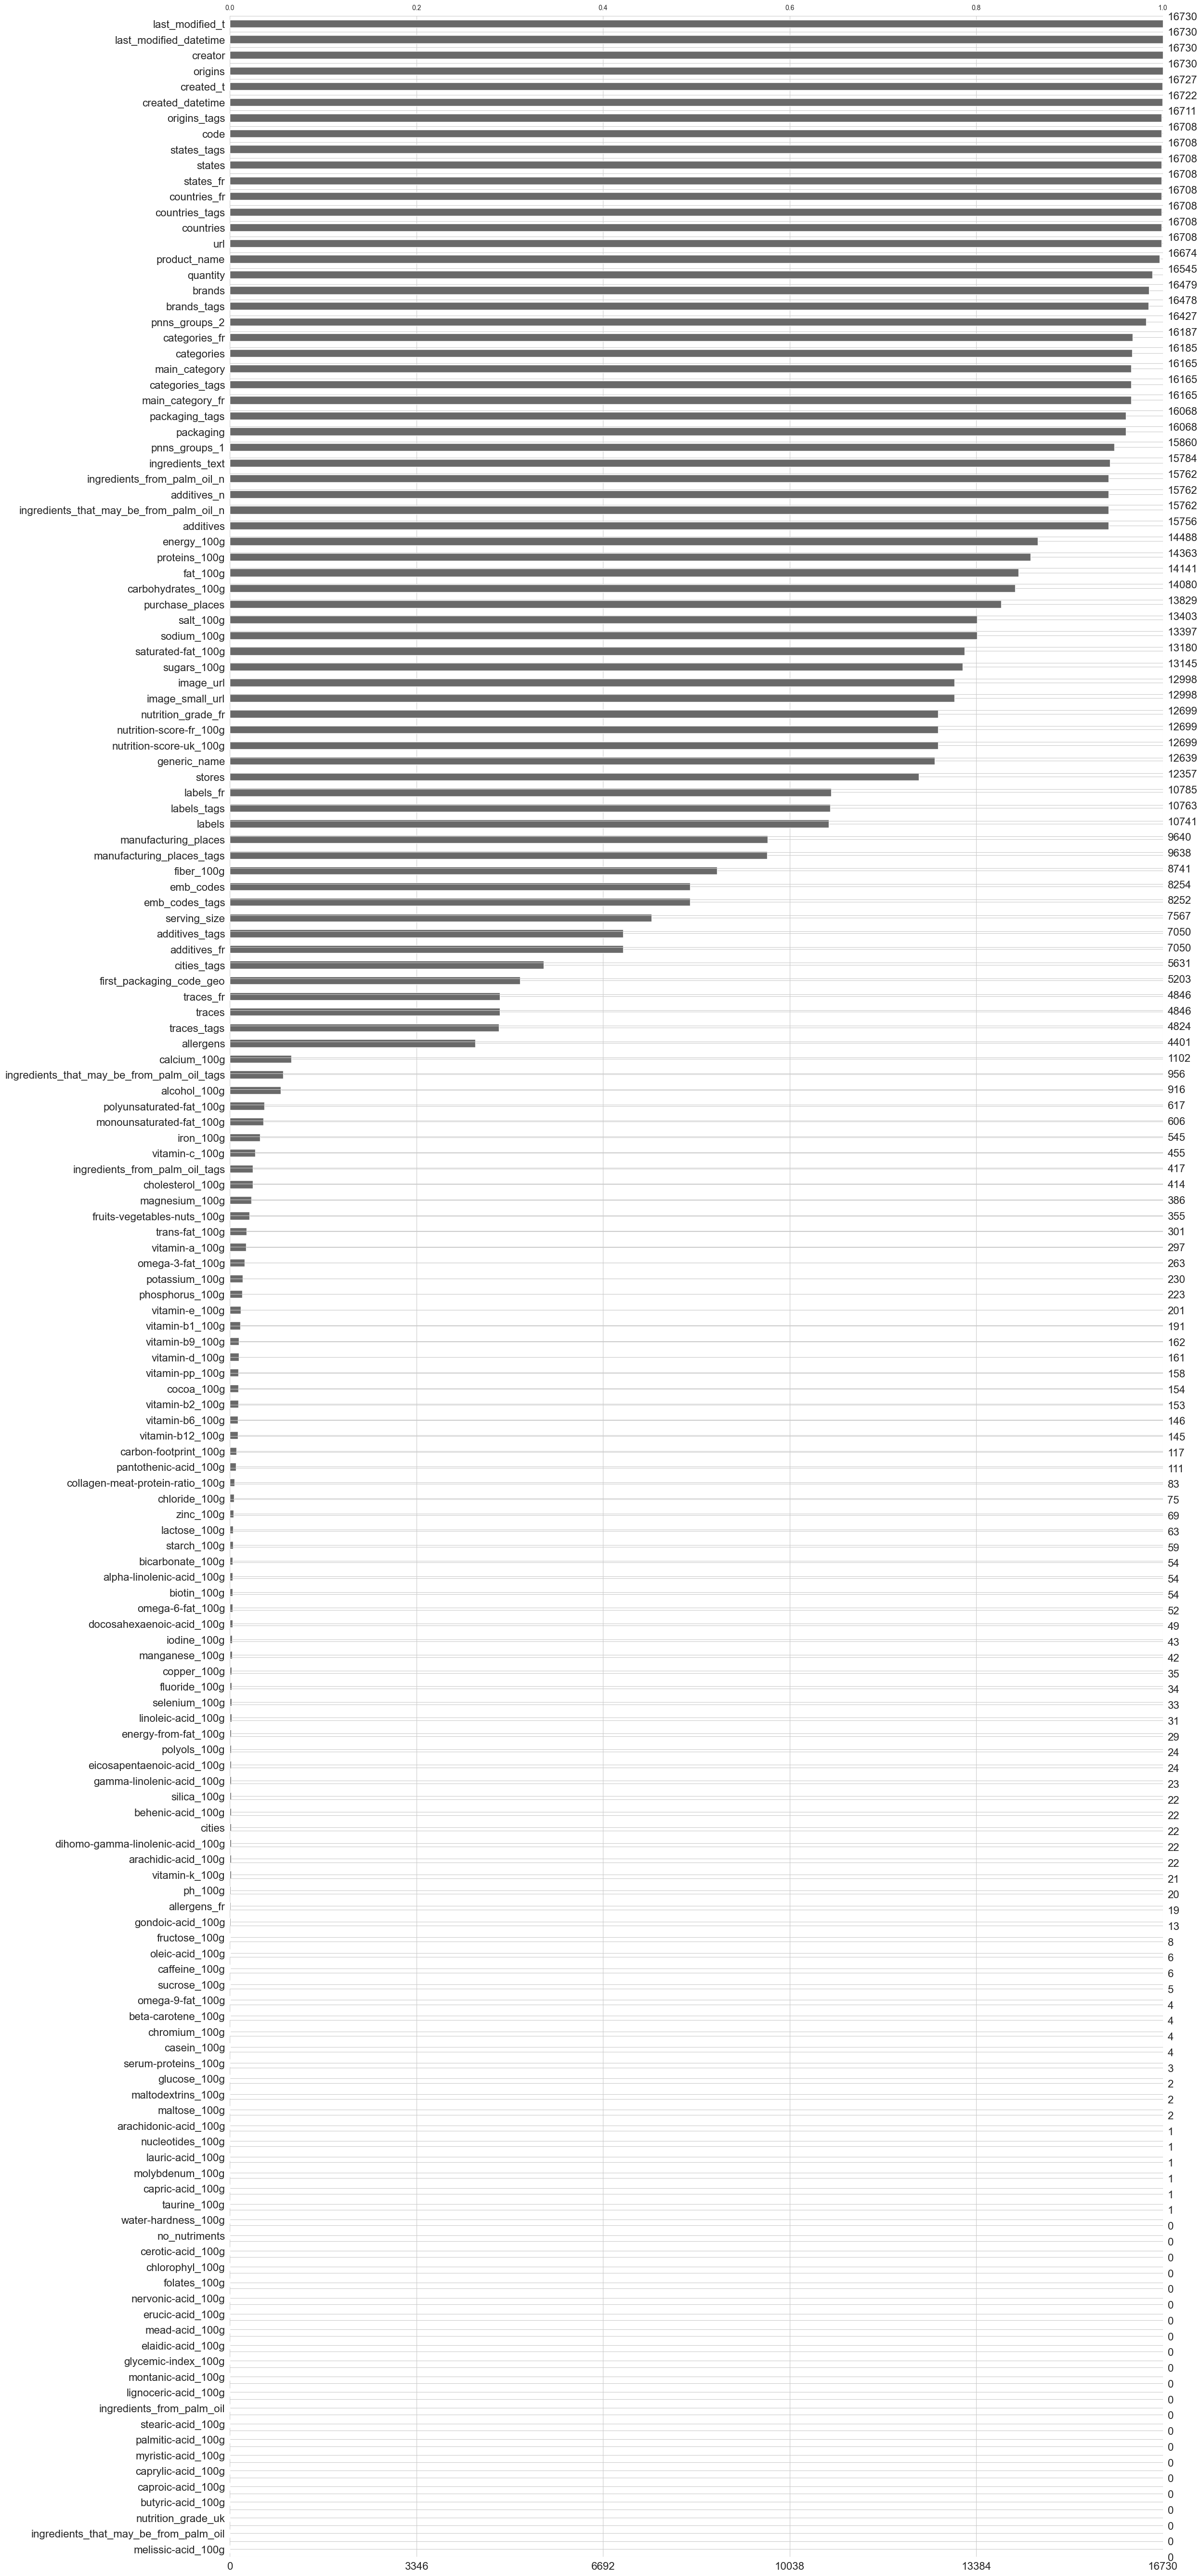

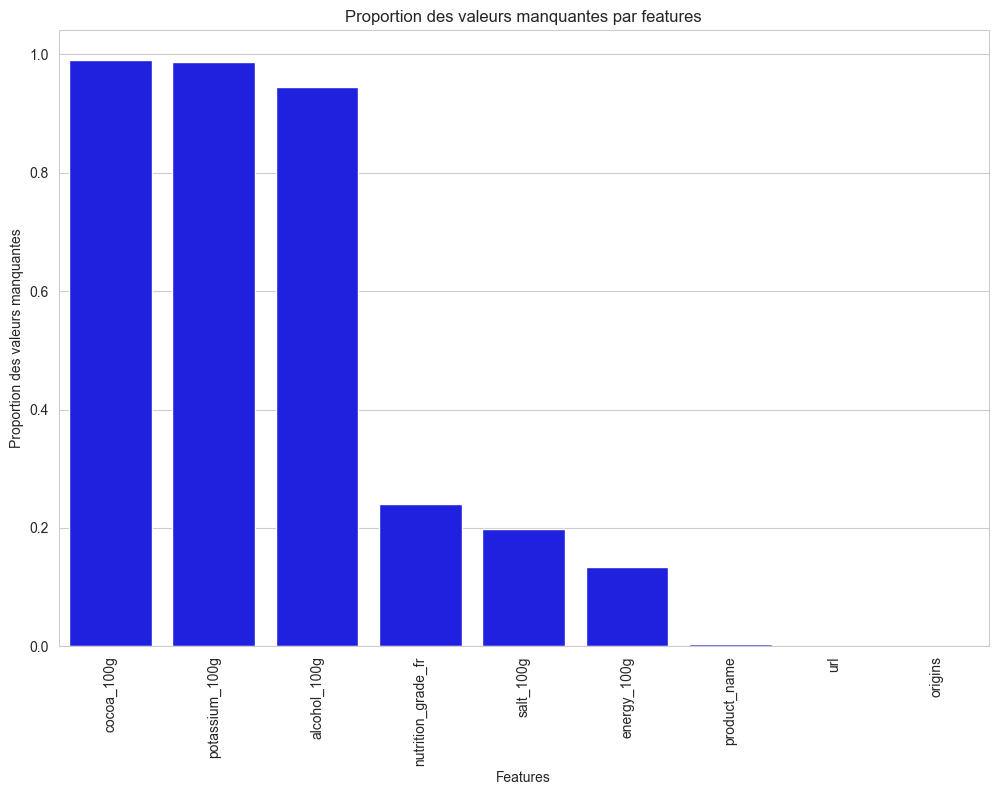

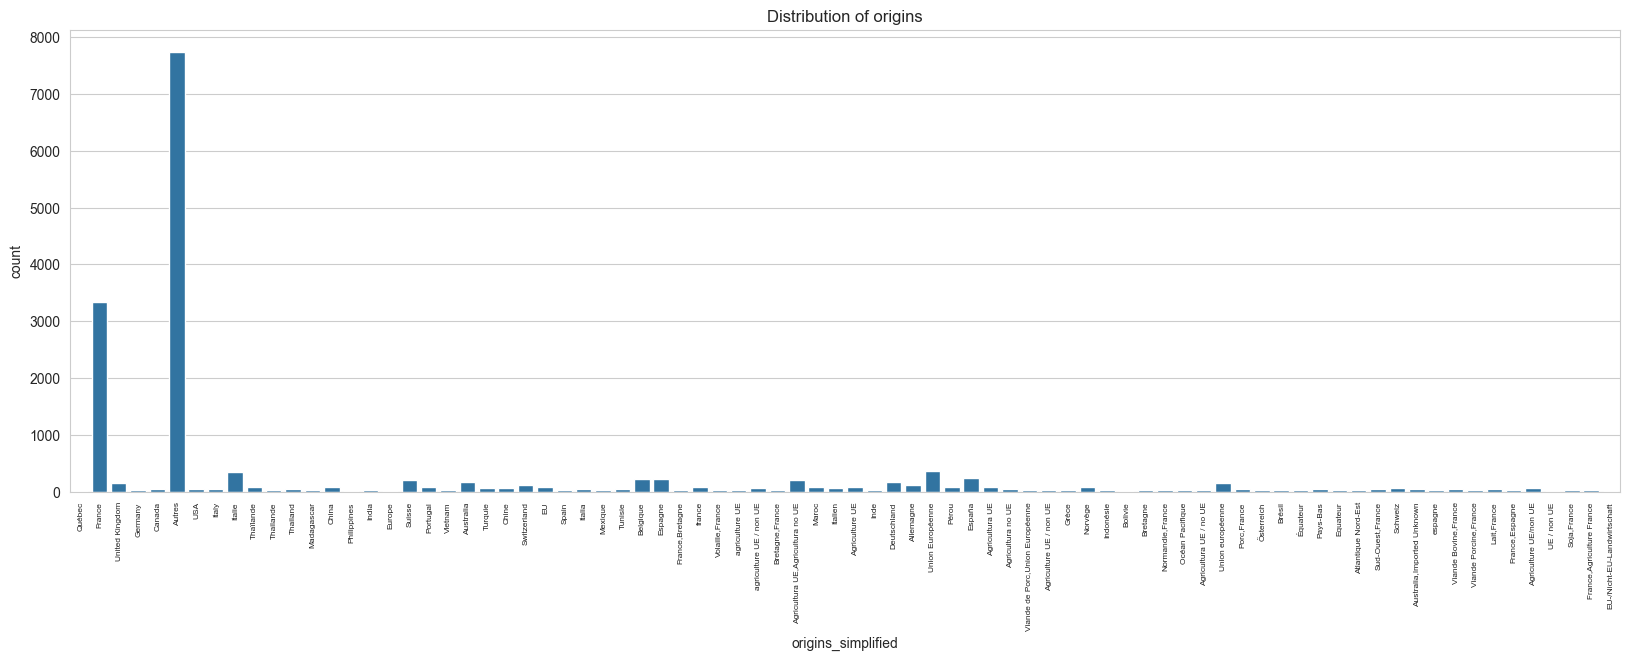

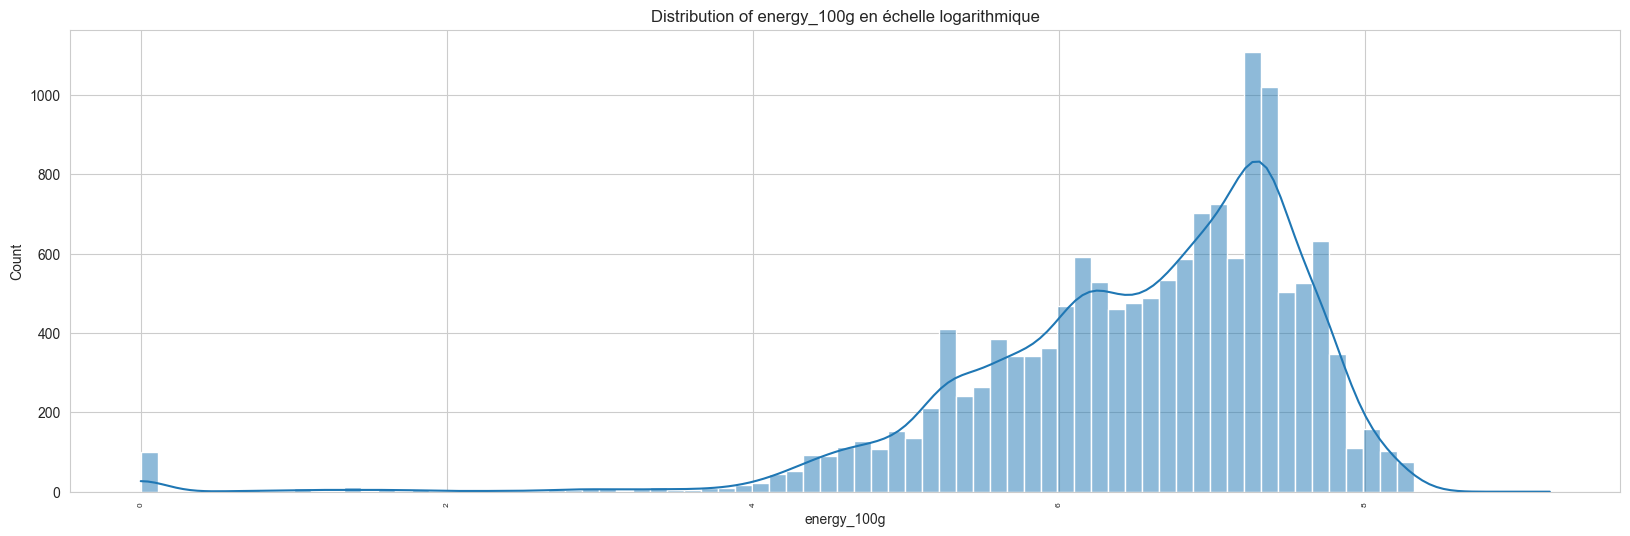

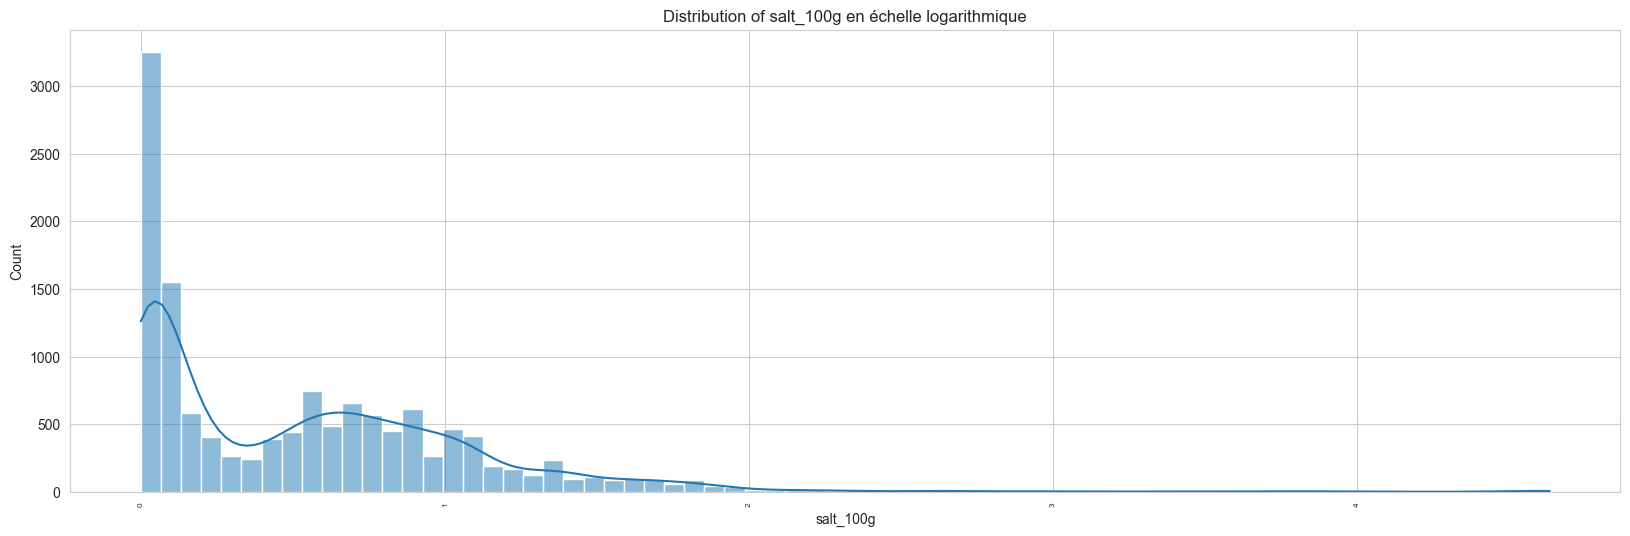

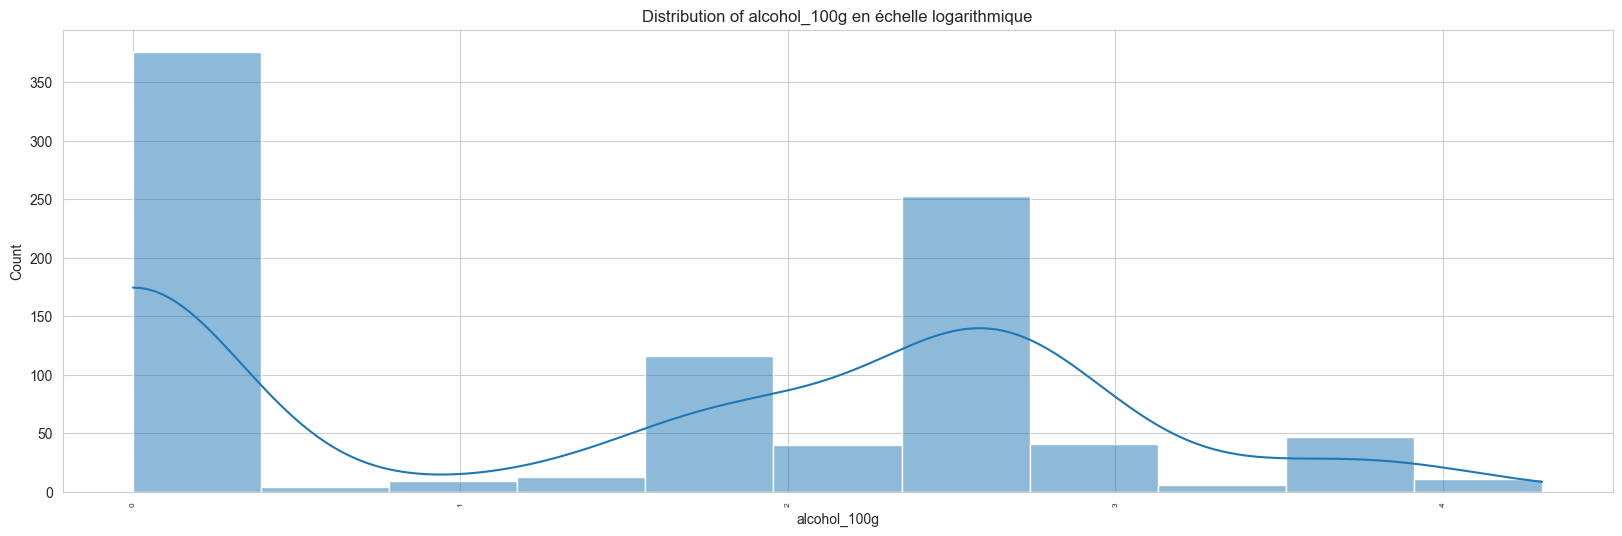

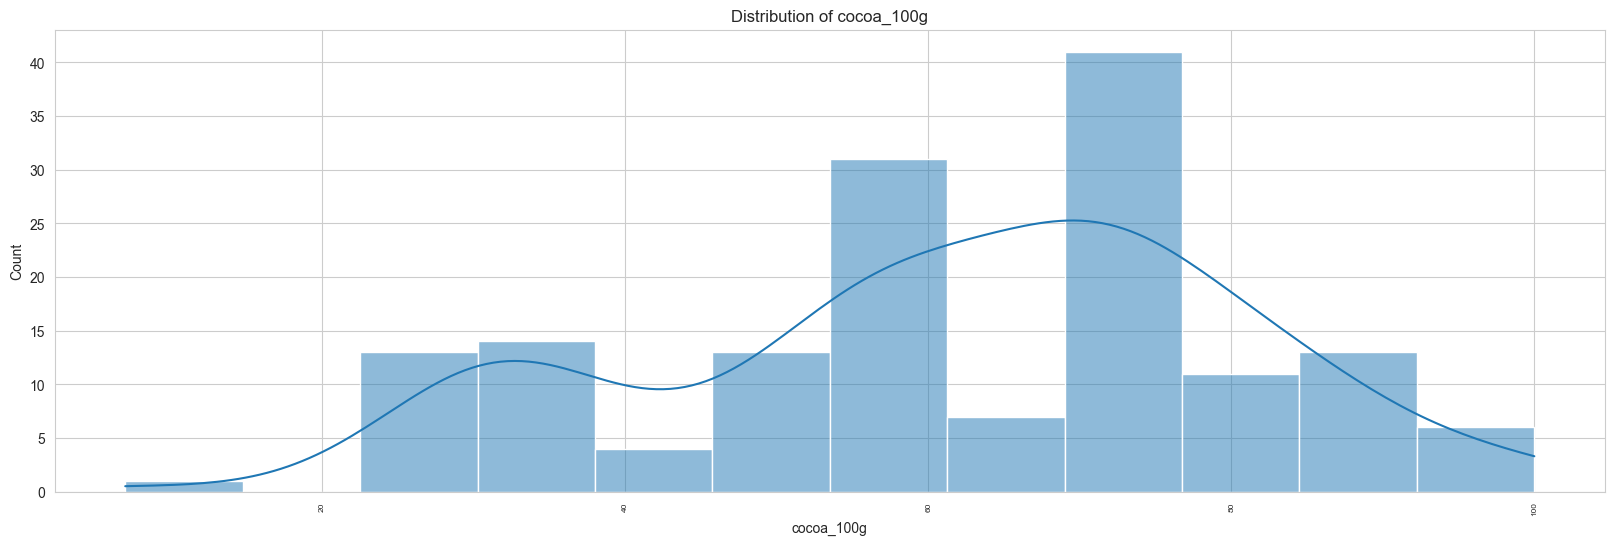

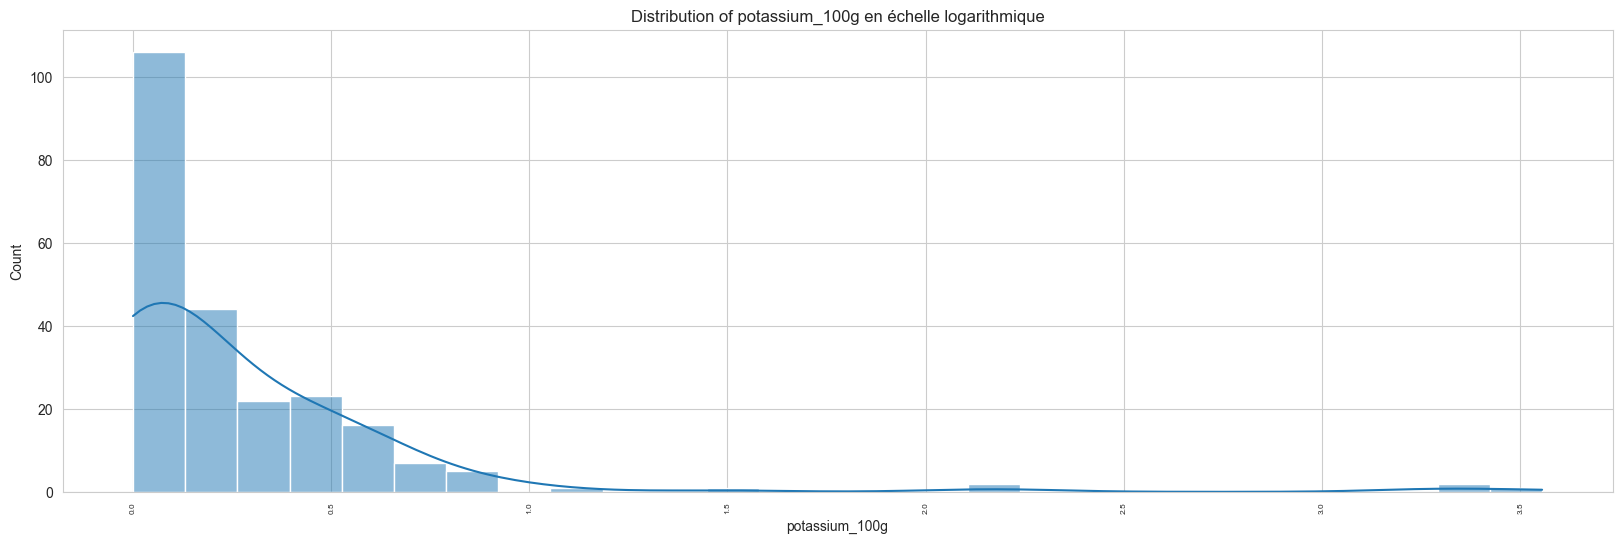

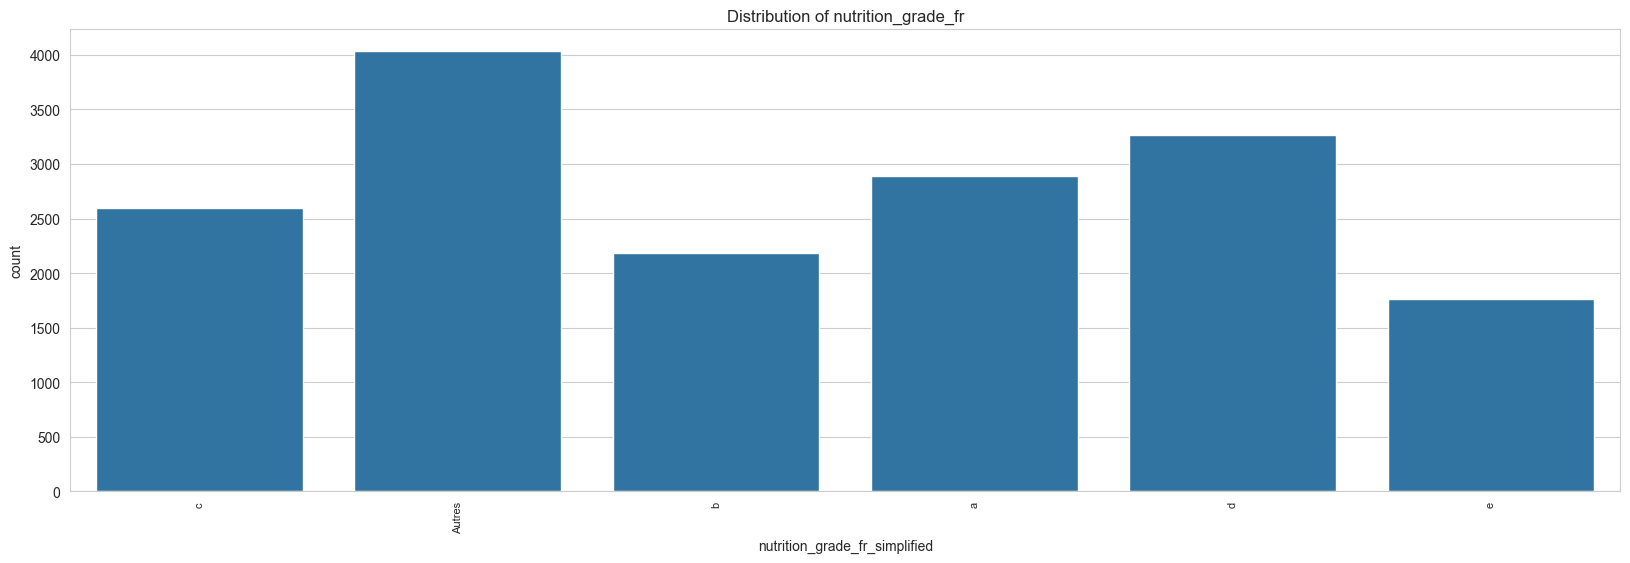

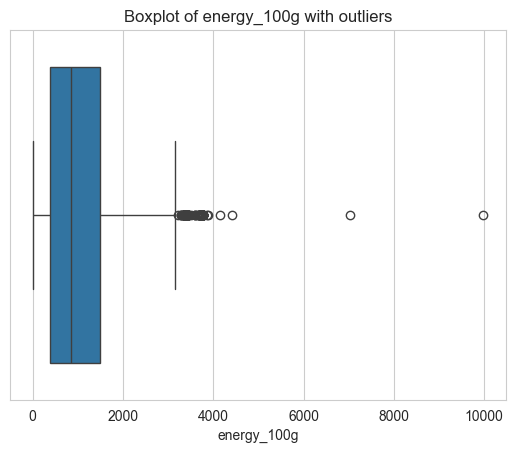

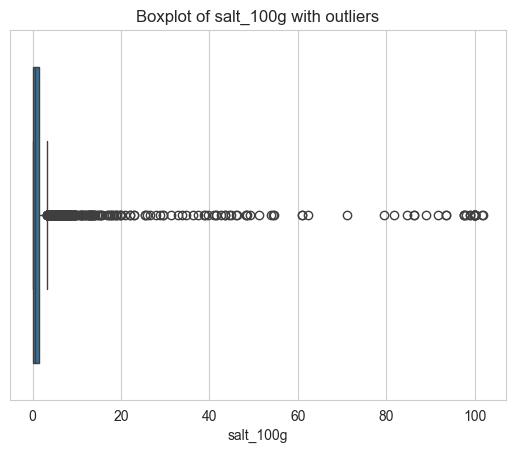

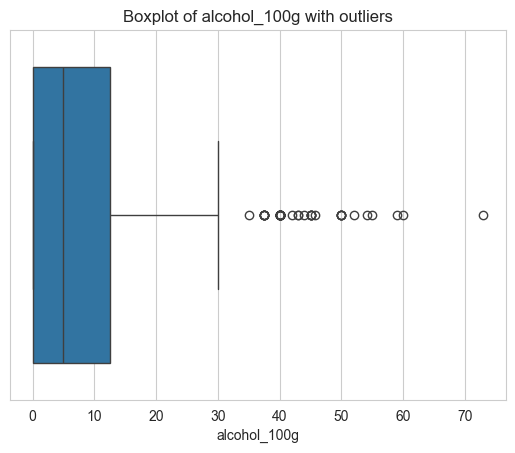

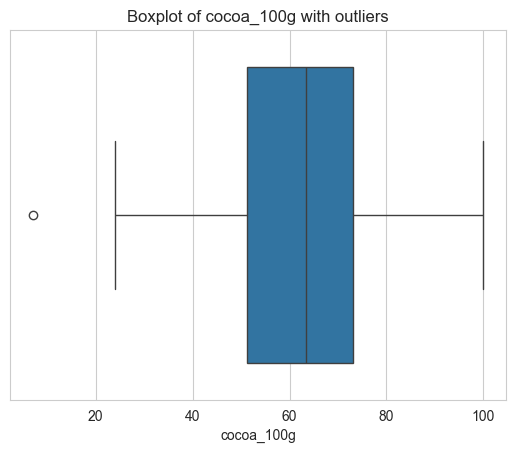

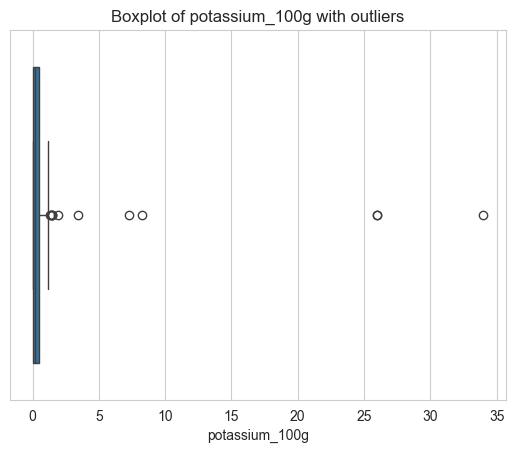

Skewness différents de 0, ici: 1.04 et kurtosis différents de 3, ici: 5.01


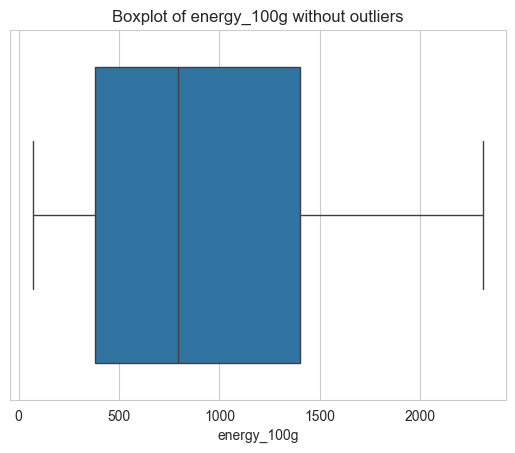

Skewness différents de 0, ici: 16.42 et kurtosis différents de 3, ici: 369.55


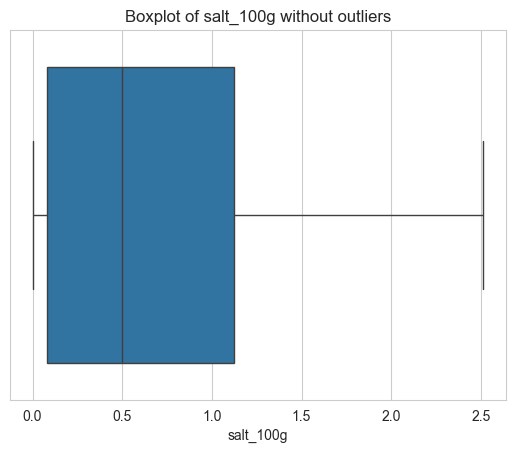

Skewness différents de 0, ici: 11.49 et kurtosis différents de 3, ici: 154.29


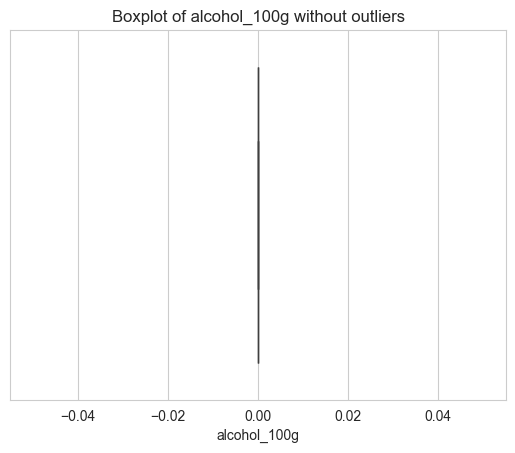

/var/folders/gk/r5q0c38n70s02t1z45pl1x400000gp/T/ipykernel_2786/782707542.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  skewness = stats.skew(feature_data)
/var/folders/gk/r5q0c38n70s02t1z45pl1x400000gp/T/ipykernel_2786/782707542.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  kurtosis = stats.kurtosis(feature_data,fisher=False)#Vrai kurtosis


Skewness différents de 0, ici: nan et kurtosis différents de 3, ici: nan


Skewness différents de 0, ici: 0.65 et kurtosis différents de 3, ici: 1.5


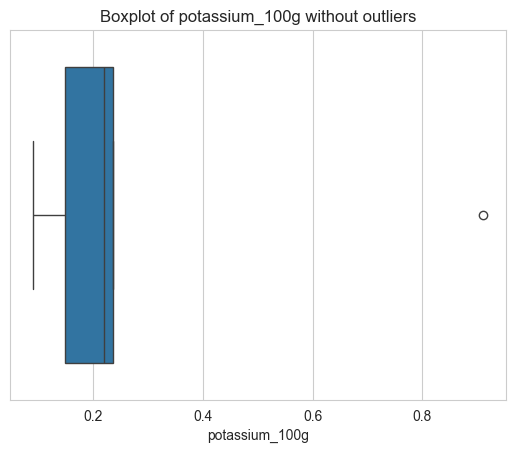

<Figure size 1000x600 with 0 Axes>

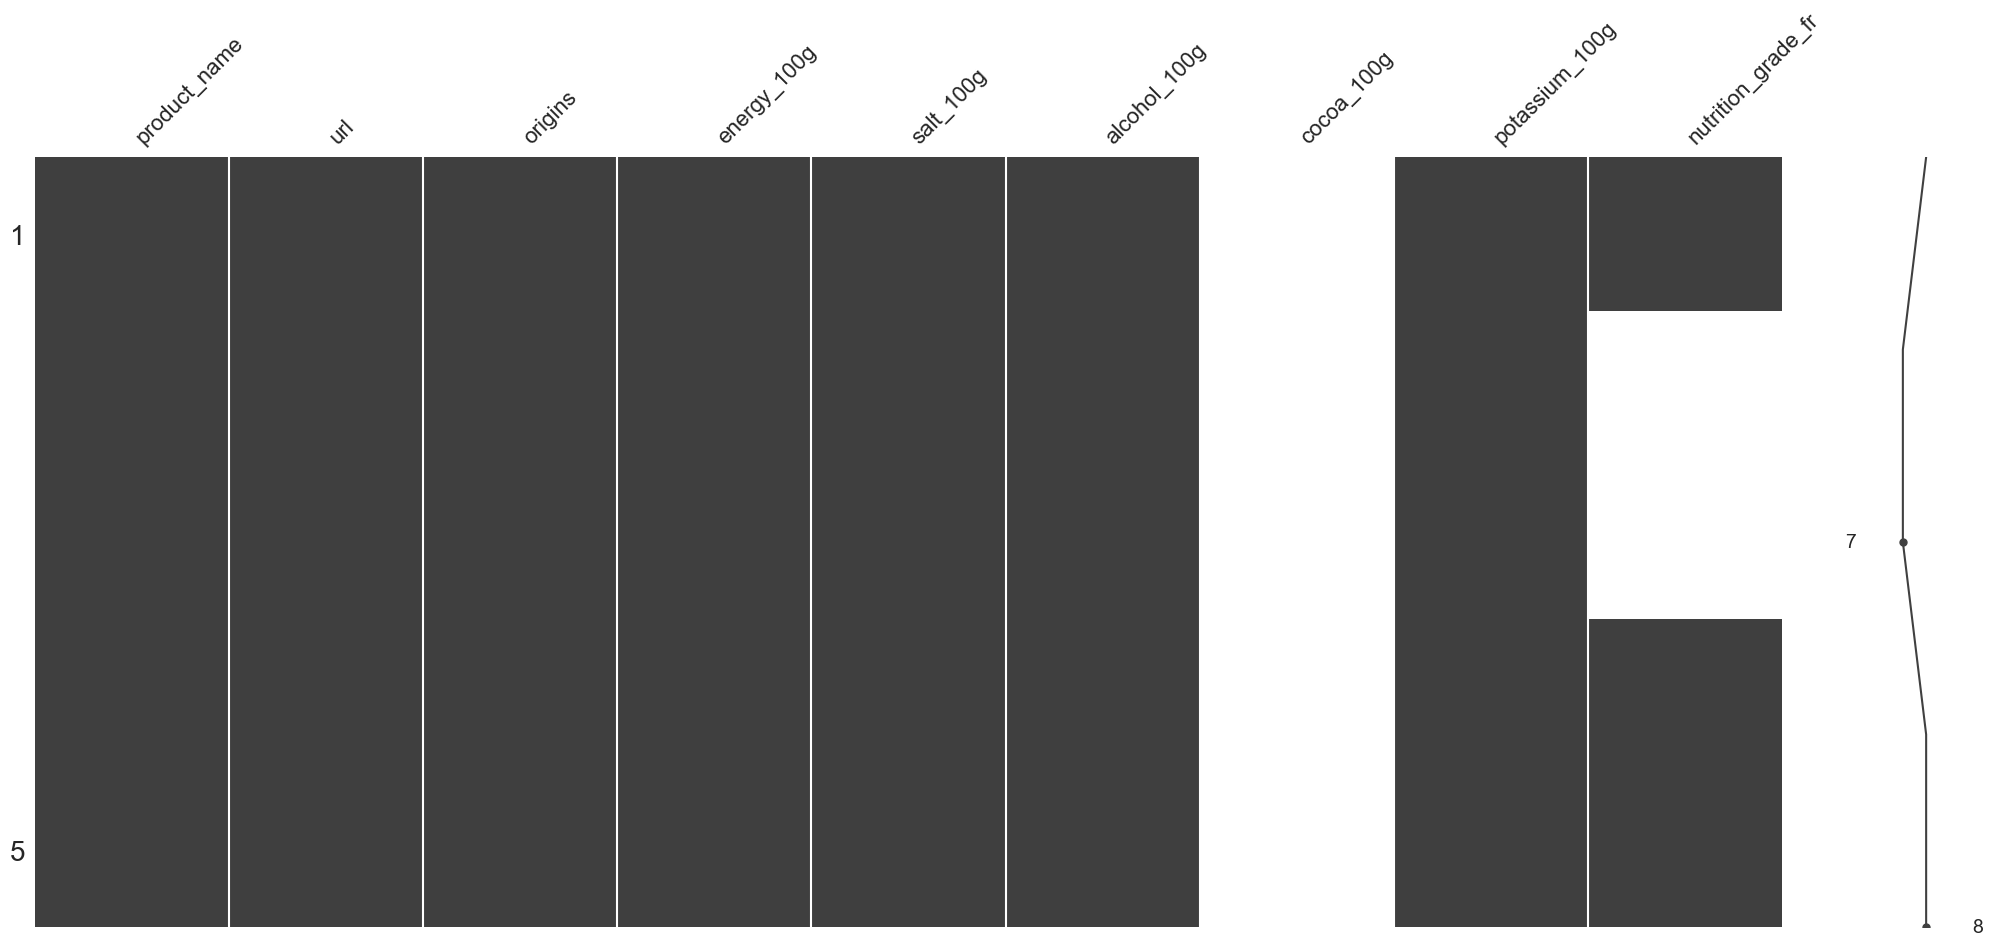

RadioButtons(description='Choix :', options=('Garder les paramètres par défaut', 'Personnaliser les options'),…

Button(description='Confirmer le choix', style=ButtonStyle())

Output()

In [103]:
def app_launch():
    filepath, target, selected, data = project_init()
    display(HTML("<h2>Nettoyer et filtrez les features et produits</h2>"))
    data_filtered,quantitative_features, qualitative_features, target, selected = clean_and_filter_features_and_products(filepath, target, selected, data)
    display(HTML("<h2>Identifiez et traitez les valeurs aberrantes</h2>"))
    data_filtered=find_and_handles_outliers(data_filtered,target,selected,quantitative_features)
    # print(data_filtered.shape)
    find_and_handles_missing_values(data_filtered)
    return data_filtered,quantitative_features, qualitative_features
data_filtered,quantitative_features,qualitative_features = app_launch()

Utilisation IQR
KNN Est tester le nombre de voisin

Shape
info describe
RGPD (Chercher les 5 grands principes)